In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1'

In [2]:
# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")
    
#device = "cpu"

MPS device found.


In [3]:
# config
cfg_dim = 64

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 2: pizza and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

In [4]:
import requests
import zipfile
from pathlib import Path

In [5]:
# Setup path to data folder
parent_path = Path().resolve().parents[0] # gets parent directory
data_path = parent_path / "data"
image_path = data_path / "pizza_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory")
    
    # Download pizza, steak, sushi data
    #with open(data_path / "pizza_sushi.zip", "wb") as f:
    #    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    #    print("Downloading pizza, steak, sushi data...")
    #    f.write(request.content)

    # Unzip pizza, steak, sushi data
    #with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    #    print("Unzipping pizza, steak, sushi data...") 
    #    zip_ref.extractall(image_path)

/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi directory exists.


You can see an example of the storage format below, the images numbers are arbitrary.

```
pizza_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi'.
There are 2 directories and 1 images in '/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/test'.
There are 0 directories and 31 images in '/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/test/sushi'.
There are 0 directories and 25 images in '/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/test/pizza'.
There are 2 directories and 1 images in '/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/train'.
There are 0 directories and 72 images in '/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/train/sushi'.
There are 0 directories and 78 images in '/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/train/pizza'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/train'),
 PosixPath('/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/test'))

In [9]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

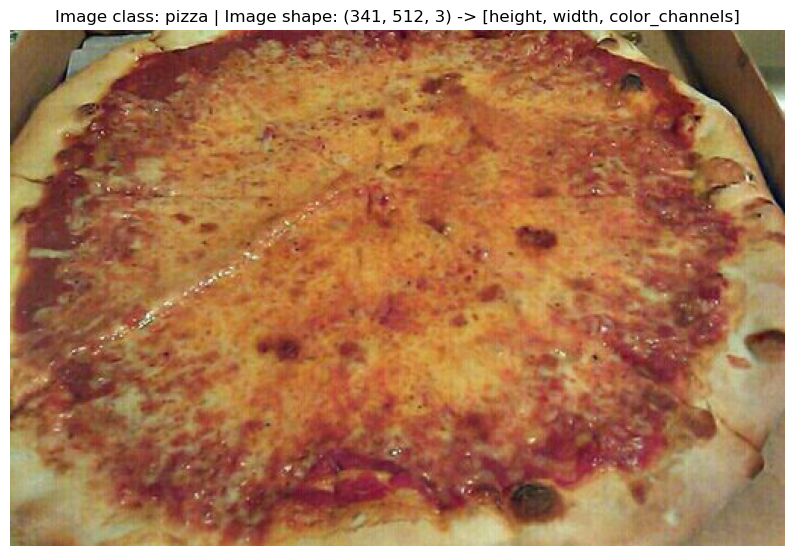

In [10]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on. 

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation**

In [12]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(cfg_dim, cfg_dim)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    #  this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.ToTensor() 
])

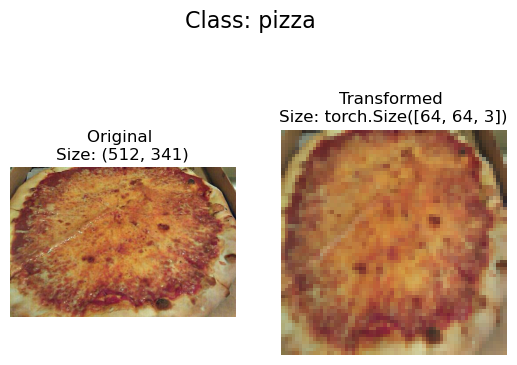

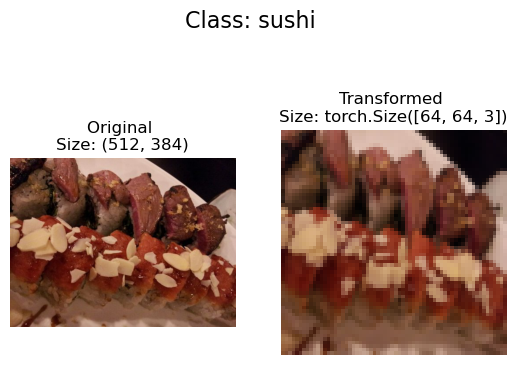

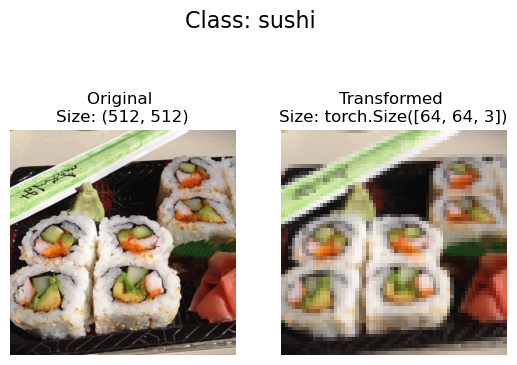

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

Since our data filestructure is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

In [14]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform,
                                 target_transform=None)# transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)


print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: /Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 56
    Root location: /Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'sushi']

In [16]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'sushi': 1}

In [17]:
# Check the lengths
len(train_data), len(test_data)

(150, 56)

In [18]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


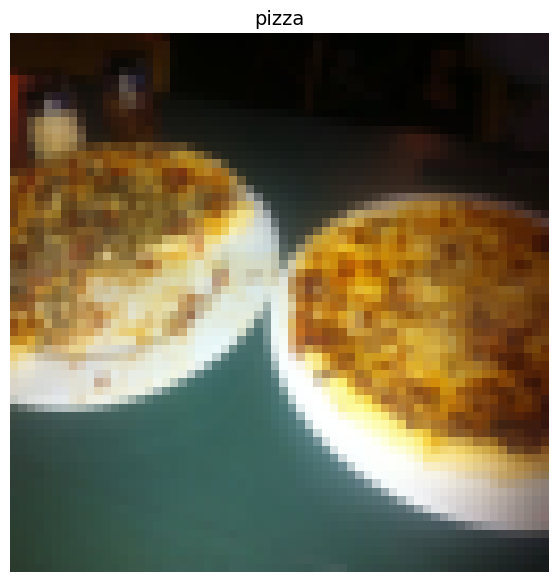

In [19]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`which defines how many subprocesses will be created to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count). Or if using MPS my m2 macbook air has 16 machine learning cores

In [20]:
from torch.utils.data import DataLoader

In [21]:
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=1,# samples per batch
                             num_workers=0,# cores/threads to use
                             shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=0,
                            shuffle=False)# no reason to shuffle test data
# i got errors when i tried 16 cores. not sure if it's using cpu or mps

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1694c69d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1696d8510>)

now our data is iterable

In [22]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

what are the pros and cons of creating your own custom way to load `Dataset`'s?

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. | 
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

In [23]:
import os
from typing import Tuple, Dict, List
import pathlib

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

In [24]:
# setup path for target directory
target_directory = train_dir

# get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Class names found: ['.DS_Store', 'pizza', 'sushi']


In [25]:
# oops we don't want .DS_store in there
class_names_found = class_names_found[1:]
class_names_found

['pizza', 'sushi']

In [26]:
# turning that code into a full function
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    """
    finds class folder names in a target directory
    assumes standard image classification format
    
    example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, "class_2": 1})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"couldn't find any classes in {directory}")
        
    # creates a dictionary of index labels since computers prefer numbers to strings
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [27]:
# test out our function
find_classes(train_dir)

(['pizza', 'sushi'], {'pizza': 0, 'sushi': 1})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

Now we're ready to build our own custom `Dataset`.

We'll build one to replicate the functionality of `torchvision.datasets.ImageFolder()`. 

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom `Dataset`.

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data). 
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

In [28]:
# writing a custom dataset class that inherits from torch.utils.data.Dataset
from torch.utils.data import Dataset

# putting "dataset" in the parenthesis makes this a subclass
# so torch.utils.data.Dataset.ImageFolderCustom
class ImageFolderCustom(Dataset):
    
    # initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # get all image paths
        # note you'd have to change this for png's or jpeg's
        # glob() method returns a list of files or folders that matches the path specified in the pathname argument
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) 
        
        # setup transforms
        self.transform = transform
        
        # create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    def load_image(self, index: int) -> Image.Image:
        """opens an image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # overwrite the __len__() method
    # optional but recommended for subclasses of torch.utils.data.Datset
    #    so that len() still works
    def __len__(self) -> int:
        return len(self.paths)
    
    # overwrite the __getitem__() method
    # required for subclasses of torch.utils.data.Datset
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """returns one sample of data, data and label (X,y)"""
        
        img = self.load_image(index)
        # expects filestructure format to indicate class name
        # data_folder/class_name/image.jpeg
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        # transform if necessary
        # return data, label (X,y)
        if self.transform:
            # return data, label (X,y)
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [29]:
# augment training data
train_transforms = transforms.Compose([
    transforms.Resize((cfg_dim,cfg_dim)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() 
])

# don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((cfg_dim,cfg_dim)),
    transforms.ToTensor()
])

Now comes the moment of truth!

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `ImageFolderCustom` class.

In [30]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                     transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x169722950>,
 <__main__.ImageFolderCustom at 0x16969bc10>)

In [31]:
len(train_data_custom), len(test_data_custom)

(150, 56)

In [32]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'sushi'], {'pizza': 0, 'sushi': 1})

In [33]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [34]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):

    # adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"for display purposes, n shouldn't be larger than 10")
        
    # for replication
    if seed:
        random.seed(seed)
        
    # choose random images
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # setup plot
    plt.figure(figsize=(16,8))
    
    # loop thru samples & display them
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # adjust image tensor shape for plotting
        # [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1,2,0)
        
        # plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

let's test it out with both datasets we created, the off-the-shelf method and the custom version

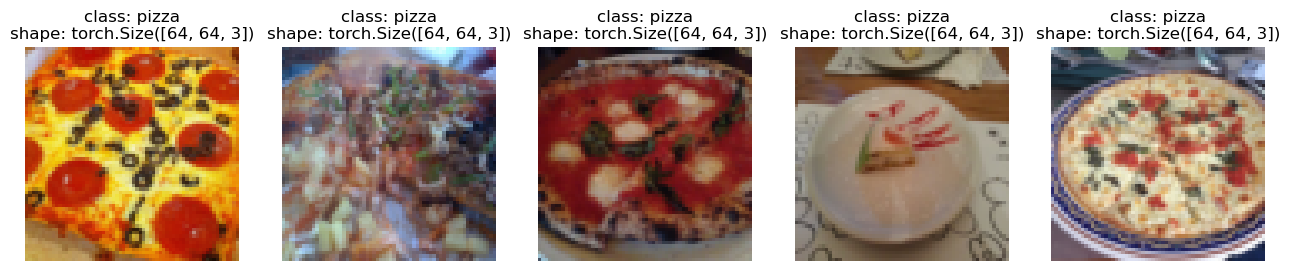

In [35]:
display_random_images(train_data,
                     n=5,
                     classes=class_names,
                     seed=None)

for display purposes, n shouldn't be larger than 10


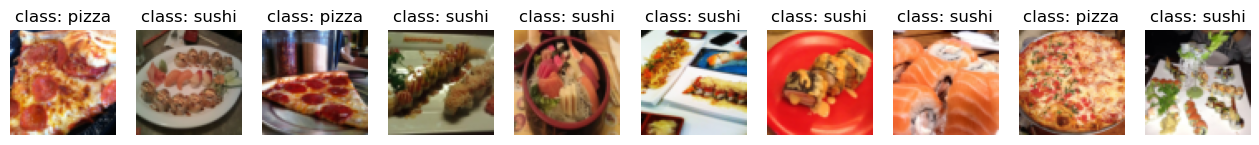

In [36]:
display_random_images(train_data_custom,
                     n=12,
                     classes=class_names,
                     seed=None)

Now how could we turn our custom `Dataset`'s into `DataLoader`'s?

Because our custom `Dataset`'s subclass is`torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.


In [37]:
%time
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 40.1 µs


(<torch.utils.data.dataloader.DataLoader at 0x1699acd90>,
 <torch.utils.data.dataloader.DataLoader at 0x16962bc90>)

In [38]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Other forms of transforms (data augmentation)
You can see them all in the [`torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity). 

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

In [39]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

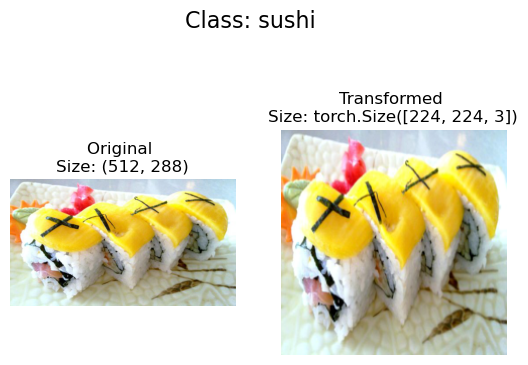

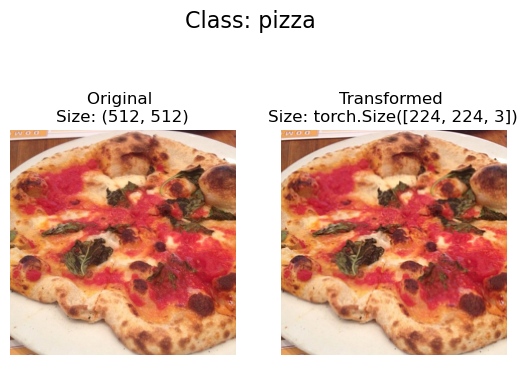

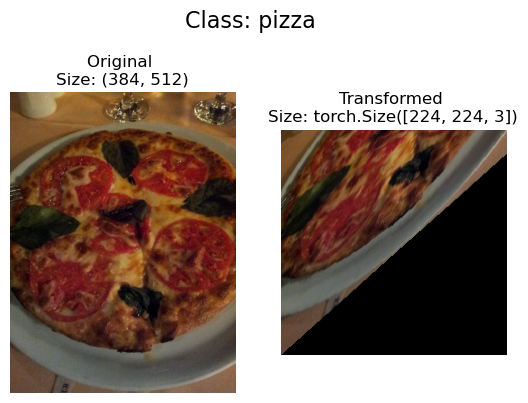

In [40]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## Model 0: TinyVGG without data augmentation


In [41]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [42]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x169d29e50>,
 <torch.utils.data.dataloader.DataLoader at 0x169c824d0>)

In [58]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        
        # since this is a subclass to nn.Module(), we can copy all the
        # stuff in the __init__() of the superclass
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, #size of conv square
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel block
        ).to(device)
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ).to(device)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # i'm too lazy and dont' care enough about convolutions
            # to think about why *16*16 makes sense
            nn.Linear(in_features=hidden_units*16*16,
                        out_features=output_shape)
        ).to(device)
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x.type(torch.float32).to(device))))

In [59]:
model_0 = TinyVGG(input_shape=3, #number of color channels, 3 for RGB
                 hidden_units=3,
                 output_shape=1
                # THIS IS HACKY AF
                # BASICALLY I"M FORCING A MULTI-CLASS MODEL TO BE BINARY
                 ).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=1, bias=True)
  )
)

### Try a forward pass on a single image (to test the model)

In [46]:
# to make torch.round() work on the CPU as backup since it's 
# not available for MPS
if device == "mps":
    import os                                                                              
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'                                        
    print(os.environ['PYTORCH_ENABLE_MPS_FALLBACK'])  
# but for me this didn't actually work, error stayed the same

1


In [45]:
# instead of fixing this mps issue i just wrote my own efficient
# alternative to torch.round()
def custom_round(tensor):
    return torch.floor(tensor + 0.5)

# optional version that would let you specify decimals
#def custom_round(tensor, decimals=0):
#    multiplier = 10.0 ** decimals
#    return torch.floor((tensor * multiplier) + 0.5) / multiplier

In [46]:
# get batch of images
img_batch, label_batch = next(iter(train_dataloader_simple))

# get single image from batch & unsqueeze so shape fits model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# perform fwd pass on single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# print what's happening & convert logits to pred label
print(f"Output logits:\n{pred}\n")
#print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction probabilities:\n{torch.sigmoid(pred)}\n")
#print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Output prediction label:\n{custom_round(torch.sigmoid(pred))}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0406]], device='mps:0')

Output prediction probabilities:
tensor([[0.5102]], device='mps:0')

Output prediction label:
tensor([[1.]], device='mps:0')

Actual label:
0


a helpful way to get information from our model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo).

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

In [47]:
import torchinfo
from torchinfo import summary

In [48]:
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 3, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            84
│    └─ReLU: 2-2                         [1, 3, 64, 64]            --
│    └─Conv2d: 2-3                       [1, 3, 64, 64]            84
│    └─ReLU: 2-4                         [1, 3, 64, 64]            --
│    └─MaxPool2d: 2-5                    [1, 3, 32, 32]            --
├─Sequential: 1-2                        [1, 3, 16, 16]            --
│    └─Conv2d: 2-6                       [1, 3, 32, 32]            84
│    └─ReLU: 2-7                         [1, 3, 32, 32]            --
│    └─Conv2d: 2-8                       [1, 3, 32, 32]            84
│    └─ReLU: 2-9                         [1, 3, 32, 32]            --
│    └─MaxPool2d: 2-10                   [1, 3, 16, 16]            --
├─Sequential: 1

# finally we're turning our test and train loops into a function for once

In [49]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    # loop thru data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.type(torch.float32).to(device), y.type(torch.float32).to(device)
        
        # fwd pass
        print(f'X shape: ', X.shape)
        print(f'X dtype:', X.dtype)
        print(f'X device:', X.device)
        print(f'model device:', X.device)
        y_pred = model(X).squeeze()
        #y_pred = torch.nn.functional.one_hot(model(X).to(torch.int64), num_classes=2).to(device)

        
        #calc & accumulate loss
        #print(f"y_pred shape: ", y_pred.shape)
        #print(f"y_pred dtype: ", y_pred.dtype)
        #print(f"y_pred: ", y_pred[:3])
        #print(f"y shape: ", y.shape)
        #print(f"y dtype: ", y.dtype)
        #print(f"y: ", y[:3])
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # set grad to 0
        optimizer.zero_grad()
        
        # calc grad
        loss.backward()
        
        # backprop the grad
        optimizer.step()
        
        # calc & accumulate accuracy across all batches
        y_pred_class = custom_round(torch.sigmoid(y_pred))
        #y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    # adjust metrics to get avg loss & acc per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [50]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module):
    model.eval()
    
    test_loss, test_acc = 0, 0
    
    # turn on inference context manager
    with torch.inference_mode():
        # loop thru DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.type(torch.float32).to(device)
            
            # fwd pass
            test_pred_logits = model(X).squeeze()
            #test_pred_logits = torch.nn.functional.one_hot(model(X).to(torch.int64), num_classes=2).to(device)

            
            # calc & accumulate loss
            #print(f"test_pred_logits shape: ", test_pred_logits.shape)
            #print(f"test_pred_logits dtype: ", test_pred_logits.dtype)
            #print(f"test_pred_logits: ", test_pred_logits[:3])
            #print(f"y shape: ", y.shape)
            #print(f"y dtype: ", y.dtype)
            #print(f"y: ", y[:3])
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # calc & accumulate acc
            test_pred_labels = custom_round(torch.sigmoid(test_pred_logits))
            #test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
            
    # adjust metrics to get avg loss & acc per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc

In [51]:
# to keep track of the number of epochs this is a progress bar
from tqdm.auto import tqdm

In [52]:
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
         epochs: int = 3):
    
    # create empty results dict
    results = {"train_loss": [],
                "train_acc": [],
              "test_loss": [],
              "test_acc": []}
    
    # loop thru train & test steps for num of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # print what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [60]:
NUM_EPOCHS = 2

model_0 = TinyVGG(input_shape=3, # of color channels
                 hidden_units=3,
                 output_shape=1 
                # THIS IS HACKY AF
                # BASICALLY I"M FORCING A MULTI-CLASS MODEL TO BE BINARY
                 ).to(device)

loss_fn = nn.BCELoss()
#loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.005)

In [54]:
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 3, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            84
│    └─ReLU: 2-2                         [1, 3, 64, 64]            --
│    └─Conv2d: 2-3                       [1, 3, 64, 64]            84
│    └─ReLU: 2-4                         [1, 3, 64, 64]            --
│    └─MaxPool2d: 2-5                    [1, 3, 32, 32]            --
├─Sequential: 1-2                        [1, 3, 16, 16]            --
│    └─Conv2d: 2-6                       [1, 3, 32, 32]            84
│    └─ReLU: 2-7                         [1, 3, 32, 32]            --
│    └─Conv2d: 2-8                       [1, 3, 32, 32]            84
│    └─ReLU: 2-9                         [1, 3, 32, 32]            --
│    └─MaxPool2d: 2-10                   [1, 3, 16, 16]            --
├─Sequential: 1

In [56]:
from timeit import default_timer as timer

In [61]:
start_time = timer()

#train
model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([22, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
Epoch: 1 | train_loss: 10.6150 | train_acc: 0.4841 | test_loss: 0.7001 | test_acc: 0.6094
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([22, 3, 64, 64])

In [62]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [63]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

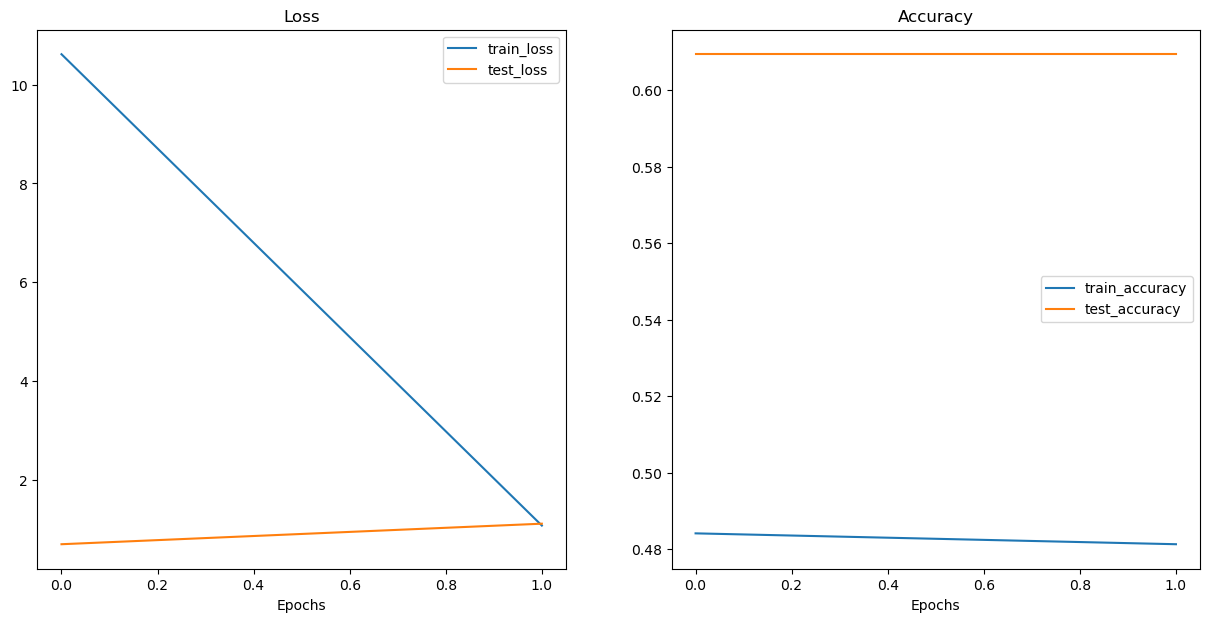

In [64]:
plot_loss_curves(model_0_results)

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. | 
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. | 
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. | 
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. | 
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

## Model 1: TinyVGG with Data Augmentation

In [65]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [66]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 150
     Root location: /Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 56
     Root location: /Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/pizza_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [67]:
BATCH_SIZE = 32
NUM_WORKERS = 4

train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x28e2df4d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1696d8510>)

In [68]:
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=3,
    output_shape=1
    ).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=1, bias=True)
  )
)

In [69]:
# Set number of epochs
NUM_EPOCHS = 2

# Setup loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer

In [70]:
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([22, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
Epoch: 1 | train_loss: 9.0006 | train_acc: 0.5188 | test_loss: 0.8517 | test_acc: 0.6094
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([32, 3, 64, 64])
X dtype: torch.float32
X device: mps:0
model device: mps:0
X shape:  torch.Size([22, 3, 64, 64])


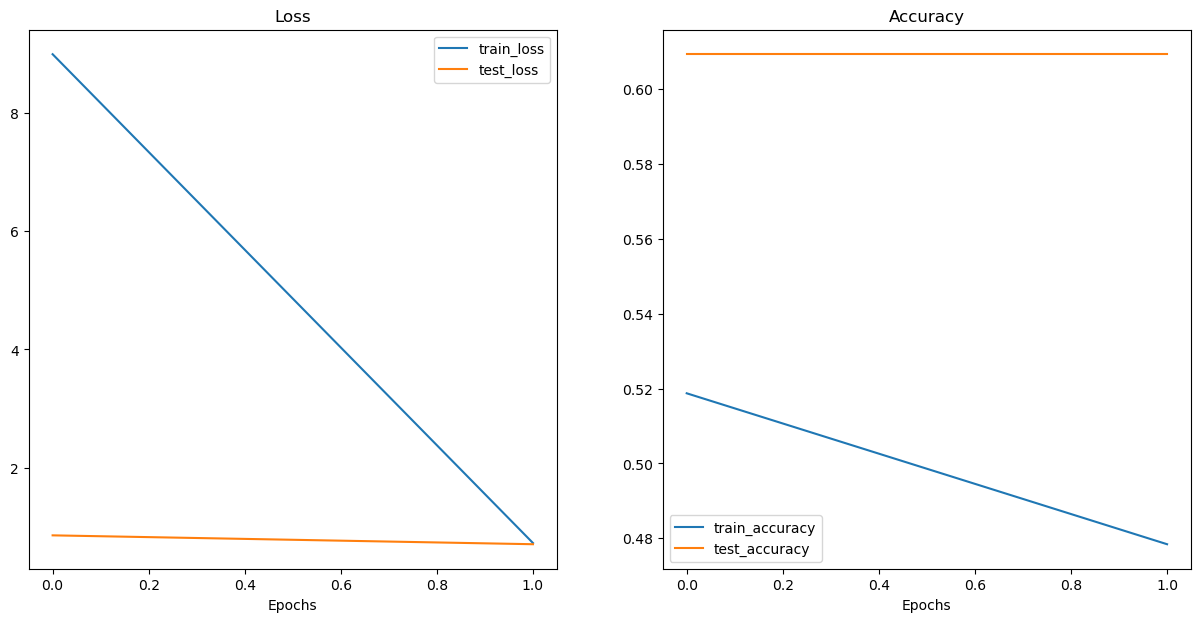

In [71]:
plot_loss_curves(model_1_results)

## Compare model results

In [72]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,10.615035,0.484091,0.700142,0.609375
1,1.077625,0.481250,1.115654,0.609375


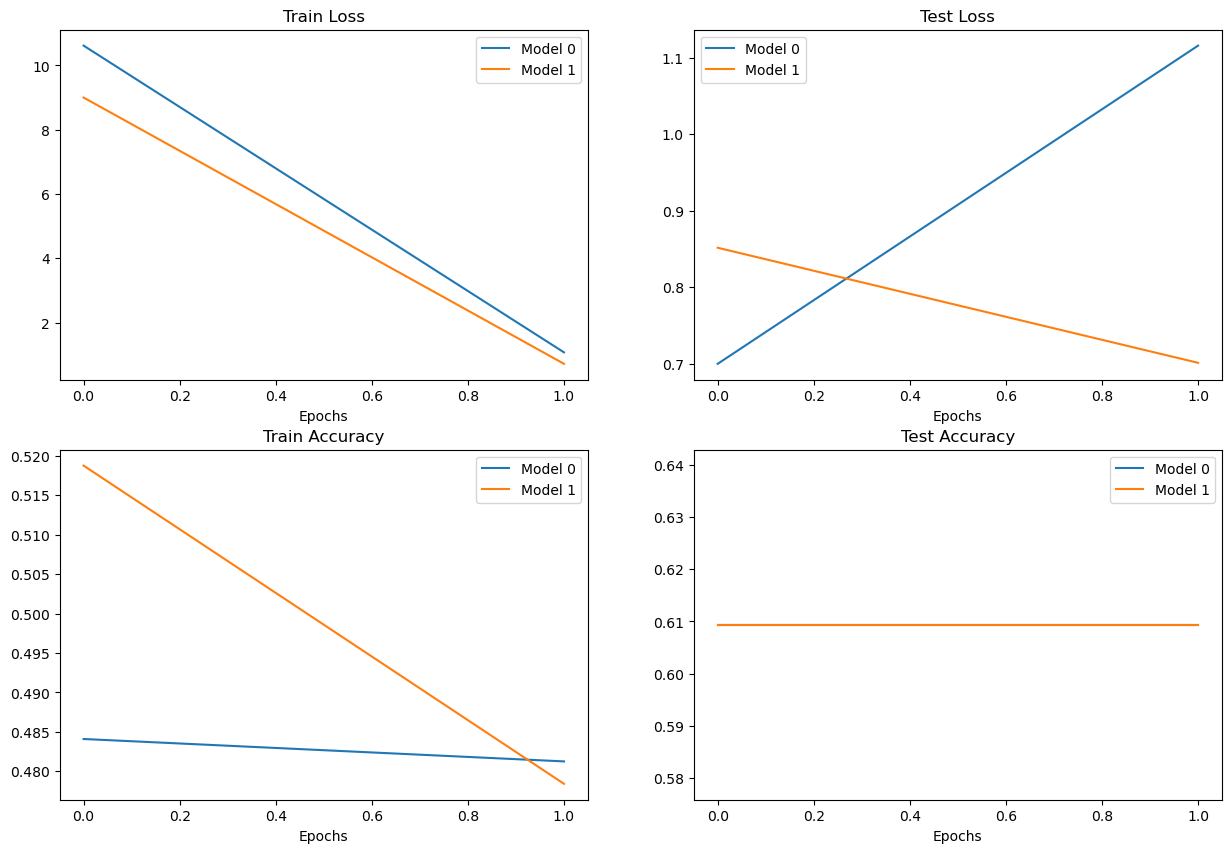

In [73]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Make a prediction on a custom image

In [74]:
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

/Users/tunadorable/Local_Repositories/pytorch-deep-learning/data/04-pizza-dad.jpeg already exists, skipping download.


In [75]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [76]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

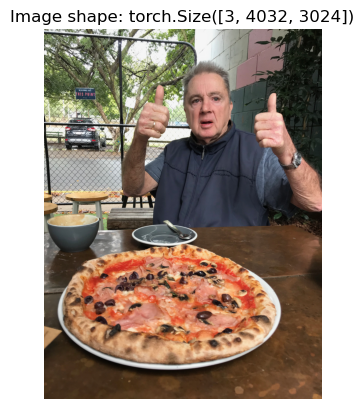

In [77]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [78]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


/Users/tunadorable/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [79]:
model_1.eval()
with torch.inference_mode():
    # add an extra dimension to image for batch size
    # got i hate this guy's choice for variable names
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [80]:
custom_image_pred

tensor([[0.4808]], device='mps:0')

In [85]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.sigmoid(custom_image_pred).squeeze()
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = custom_round(custom_image_pred_probs)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[0.4808]], device='mps:0')
Prediction probabilities: 0.6179269552230835
Prediction label: 1.0


We can convert it to a string class name prediction by indexing on the `class_names` list.

In [87]:
# Find the predicted label
# put pred label to integer on CPU, otherwise will error
custom_image_pred_class = class_names[custom_image_pred_label.type(torch.int64).cpu()] 
custom_image_pred_class

'sushi'

In [94]:
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str] = None,
                       transform=None,
                       device: torch.device = device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # div by 255 to get pixels bw 0 and 1
    target_image = target_image / 255
    
    if transform:
        target_image = transform(target_image)
        
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        # add extra dim for batch dim
        target_image = target_image.unsqueeze(dim=0)
        
        # make prediction
        target_image_pred = model(target_image.to(device))
    
    # if we were doing multi-class w crossEntropyLoss
    #target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    #target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # but we're doing a hacky binary classificaiton model w BCELoss
    target_image_pred_label = custom_round(torch.sigmoid(target_image_pred))
    
    # plot
    plt.imshow(target_image.squeeze().permute(1,2,0)) # cuz matplotlib likes h,w,c instead of c,h,w
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.squeeze().type(torch.int64).cpu()]} | Prob: {torch.sigmoid(target_image_pred).squeeze().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label.squeeze().type(torch.int64)} | Prob: {torch.sigmoid(target_image_pred).squeeze().cpu():.3f}"
    plt.title(title)
    plt.axis(False)
    

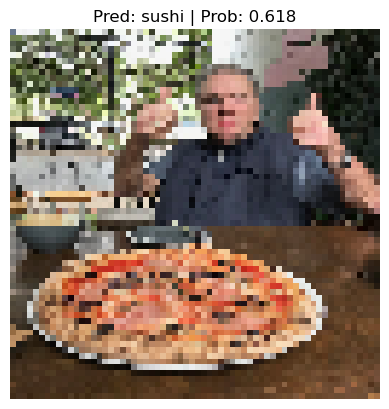

In [95]:
pred_and_plot_image(model=model_1,
                   image_path=custom_image_path,
                   class_names=class_names,
                   transform=custom_image_transform,
                   device=device)